In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [3]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 16.1 MB/s eta 0:00:00


In [4]:
#importing the dataset from huggingface dataset
from datasets import load_dataset

dataset_train = load_dataset('cifar10',split='train')

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

/usr/local/lib/python3.9/dist-packages/datasets/features/image.py:319: UserWarning: Downcasting array dtype uint8 to uint8 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4. Subsequent calls will reuse this data.


In [5]:
dataset_train

Dataset({
    features: ['img', 'label'],
    num_rows: 50000
})

In [6]:
num_classes = len(set(dataset_train['label']))
num_classes

10

In [7]:
dataset_train[3]

{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x7FDE70179760>,
 'label': 2}

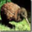

In [11]:
dataset_train[3]['img']

In [12]:
dataset_train[3]['label']

2

In [15]:
dataset_train.features['label'].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Preprocessing pipeline for the image

In [8]:
img_size = 32

#we'll use this variable preprocess in the future to preprocess the images automatically
preprocess = transforms.Compose([
                                 transforms.Resize((img_size,img_size)),
                                 transforms.ToTensor()
                                 ])

In [9]:
#another preprocessing includes haveing all the images in RGB(3d)
from tqdm.auto import tqdm
inputs_train = []

for record in tqdm(dataset_train):
  image = record['img']
  label = record['label']

  #convert from grayscale to RGB
  if image.mode == "L":
    image = image.convert["RGB"]
  
  #applying the image preprocessing pipeline
  input_tensor = preprocess(image)

  #append to the batch list
  inputs_train.append([input_tensor,label])

  0%|          | 0/50000 [00:00<?, ?it/s]

In [21]:
print(len(inputs_train),inputs_train[0][0].shape)

50000 torch.Size([3, 32, 32])


In [10]:
#calculate the mean and std.dev
import numpy as np

np.random.seed(0)

#starting to calculate the mean and std.dev by choosing a random sample size
idx = np.random.randint(0, len(inputs_train), 512)
idx.shape # we chose a random 512 images from the larger dataset 

(512,)

In [11]:
#now we concatenate this subset of image  tensors
tensors = torch.concat([inputs_train[i][0] for i in idx], axis=1)
tensors.shape

torch.Size([3, 16384, 32])

In [12]:
#merging all the values into a single 3-channel vector
tensors = tensors.swapaxes(0,1).reshape(3,-1).T
tensors.shape

torch.Size([524288, 3])

In [13]:
mean = torch.mean(tensors,axis=0)
std = torch.std(tensors,axis=0)

In [26]:
mean

tensor([0.4670, 0.4735, 0.4662])

In [14]:
#to apply all the mean and std. deviation for normalization
preprocess = transforms.Compose([
    transforms.Normalize(mean = mean, std = std) 
])

for i in tqdm(range(len(inputs_train))):
  #first preprocessing
  input_tensor = preprocess(inputs_train[i][0])
  #second replace with the normalized tensor
  inputs_train[i][0] = input_tensor

  0%|          | 0/50000 [00:00<?, ?it/s]

In [15]:
#creating a single pipeline for preprocessing
preprocess = transforms.Compose([
    transforms.Resize((img_size,img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,std=std)
])

Applying the same transformations for the validation set

In [16]:
dataset_val = load_dataset(
    'cifar10',
    split='test',  # test set (used as validation set)
)

In [17]:
from tqdm.auto import tqdm

inputs_val = []
i=0
for record in tqdm(dataset_val):
  image = record['img']
  label = record['label']

  if image.mode == 'L':
    image = image.convert("RGB")

  input_tensor = preprocess(image)
  inputs_val.append((input_tensor,label))


  0%|          | 0/10000 [00:00<?, ?it/s]

In [18]:
#add both the training and validation data into Dataloader objects
batch_size = 64

#add to dataloaders
dloader_train = torch.utils.data.DataLoader(
    inputs_train,
    batch_size = batch_size,
    shuffle=True
)

dloader_val = torch.utils.data.DataLoader(
    inputs_val,
    batch_size = batch_size,
    shuffle = False
)

In [19]:
# creating a CNN class
class ConvNeuralNet(nn.Module):
	#  determine what layers and their order in CNN object 
    def __init__(self, num_classes):
        super(ConvNeuralNet, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, padding=1)
        self.relu1 = nn.ReLU()
        self.max_pool1 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv_layer2 = nn.Conv2d(in_channels=64, out_channels=192, kernel_size=4, padding=1)
        self.relu2 = nn.ReLU()
        self.max_pool2 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv_layer3 = nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        
        self.conv_layer4 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1)
        self.relu4 = nn.ReLU()

        self.conv_layer5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.relu5 = nn.ReLU()
        self.max_pool5 = nn.MaxPool2d(kernel_size=3, stride=2)
        
        self.dropout6 = nn.Dropout(p=0.5)
        self.fc6 = nn.Linear(1024, 512)
        self.relu6 = nn.ReLU()
        self.dropout7 = nn.Dropout(p=0.5)
        self.fc7 = nn.Linear(512, 256)
        self.relu7 = nn.ReLU()
        self.fc8 = nn.Linear(256, num_classes)
    
    # progresses data across layers    
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.relu1(out)
        out = self.max_pool1(out)
        
        out = self.conv_layer2(out)
        out = self.relu2(out)
        out = self.max_pool2(out)

        out = self.conv_layer3(out)
        out = self.relu3(out)

        out = self.conv_layer4(out)
        out = self.relu4(out)

        out = self.conv_layer5(out)
        out = self.relu5(out)
        out = self.max_pool5(out)
        
        out = out.reshape(out.size(0), -1)
        
        out = self.dropout6(out)
        out = self.fc6(out)
        out = self.relu6(out)

        out = self.dropout7(out)
        out = self.fc7(out)
        out = self.relu7(out)

        out = self.fc8(out)  # final logits
        return out

In [20]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
# set the model to device
model = ConvNeuralNet(num_classes).to(device)

In [21]:
# set loss function
loss_func = nn.CrossEntropyLoss()
# set learning rate 
lr = 0.001
# set optimizer as SGD
optimizer = torch.optim.SGD(
    model.parameters(), lr=lr
) 

In [22]:
del tensors

In [23]:

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
		# load in the data in batches
    for i, (images, labels) in enumerate(dloader_train):  
        # move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # forward propagation
        outputs = model(images)
        loss = loss_func(outputs, labels)
        
        # backward propagation and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # at end of epoch check validation loss and acc
    with torch.no_grad():
      	# switch model to eval (not train) model
        model.eval()
        correct = 0
        total = 0
        all_val_loss = []
        for images, labels in dloader_val:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            total += labels.size(0)
            # calculate predictions
            predicted = torch.argmax(outputs, dim=1)
            # calculate actual values
            correct += (predicted == labels).sum().item()
            # calculate the loss
            all_val_loss.append(loss_func(outputs, labels).item())
        # calculate val-loss
        mean_val_loss = sum(all_val_loss) / len(all_val_loss)
        # calculate val-accuracy
        mean_val_acc = 100 * (correct / total)
    print(
        'Epoch [{}/{}], Loss: {:.4f}, Val-loss: {:.4f}, Val-acc: {:.1f}%'.format(
            epoch+1, num_epochs, loss.item(), mean_val_loss, mean_val_acc
        )
    )

Epoch [1/50], Loss: 2.3044, Val-loss: 2.3028, Val-acc: 10.0%
Epoch [2/50], Loss: 2.3116, Val-loss: 2.3025, Val-acc: 10.0%
Epoch [3/50], Loss: 2.2955, Val-loss: 2.3022, Val-acc: 10.0%
Epoch [4/50], Loss: 2.2963, Val-loss: 2.3019, Val-acc: 10.0%
Epoch [5/50], Loss: 2.3144, Val-loss: 2.3016, Val-acc: 10.0%
Epoch [6/50], Loss: 2.3072, Val-loss: 2.3012, Val-acc: 10.0%
Epoch [7/50], Loss: 2.2963, Val-loss: 2.3008, Val-acc: 10.0%
Epoch [8/50], Loss: 2.3022, Val-loss: 2.3004, Val-acc: 10.0%
Epoch [9/50], Loss: 2.3007, Val-loss: 2.2998, Val-acc: 10.0%
Epoch [10/50], Loss: 2.2953, Val-loss: 2.2992, Val-acc: 10.0%
Epoch [11/50], Loss: 2.3041, Val-loss: 2.2983, Val-acc: 10.1%
Epoch [12/50], Loss: 2.2962, Val-loss: 2.2972, Val-acc: 10.8%
Epoch [13/50], Loss: 2.2995, Val-loss: 2.2956, Val-acc: 11.8%
Epoch [14/50], Loss: 2.2981, Val-loss: 2.2933, Val-acc: 12.2%
Epoch [15/50], Loss: 2.2912, Val-loss: 2.2896, Val-acc: 12.1%
Epoch [16/50], Loss: 2.2925, Val-loss: 2.2826, Val-acc: 12.0%
Epoch [17/50], Lo

In [24]:
torch.save(model, 'cnn.pt')


Inference

In [26]:
import torch

model = torch.load('cnn.pt')
# switch to evaluation mode and device
model.eval().to(device)
print(device)

cuda


In [27]:
# import CIFAR-10 dataset from HuggingFace
from datasets import load_dataset

data_test = load_dataset(
    'cifar10',
    split='test'  # test set
)
data_test

Dataset({
    features: ['img', 'label'],
    num_rows: 10000
})

In [28]:
input_tensors = []
for image in data_test['img'][:10]:
    tensor = preprocess(image)
    input_tensors.append(tensor.to(device))

In [29]:
# stack into a single tensor
input_tensors = torch.stack(input_tensors)
input_tensors.shape

torch.Size([10, 3, 32, 32])

In [30]:
# process through model to get output logits
outputs = model(input_tensors)
# calculate predictions
predicted = torch.argmax(outputs, dim=1)
predicted

tensor([6, 8, 1, 8, 6, 6, 1, 6, 5, 1], device='cuda:0')

In [31]:
# here are the class names
data_test.features['label'].names


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [32]:
data_test[1]['label']


8

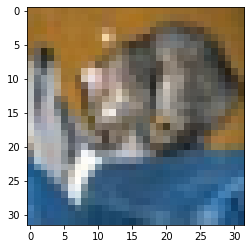

frog


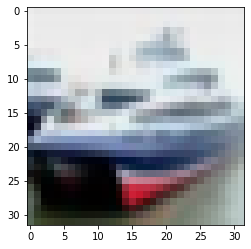

ship


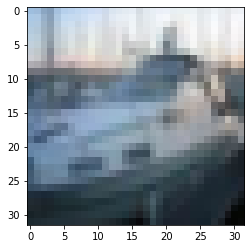

automobile


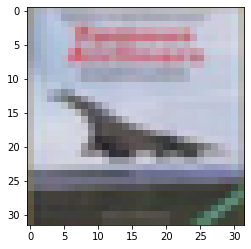

ship


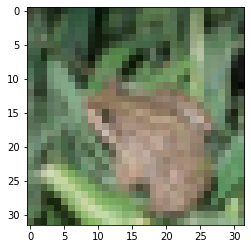

frog


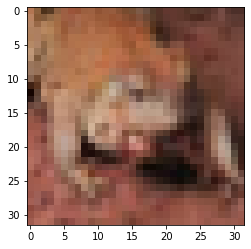

frog


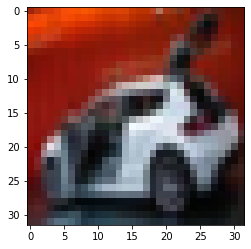

automobile


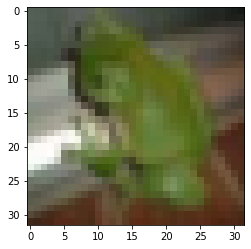

frog


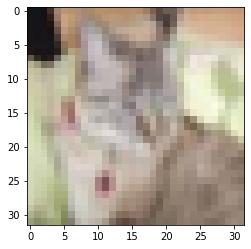

dog


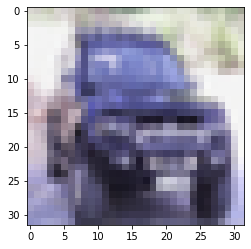

automobile


In [33]:
import matplotlib.pyplot as plt

for i, image in enumerate(data_test['img'][:10]):
    plt.imshow(image)
    plt.show()
    print(data_test.features['label'].names[predicted[i]])